# Midiendo rendimiento y riesgo con datos históricos

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/7/7d/Copper_Price_History_USD.png" width="600px" height="400px" />

> Ya sabemos que podemos caracterizar la distribución de rendimientos de un activo mediante una medida de tendencia central (media: rendimiento esperado) y una medida de dispersión (desviación estándar: volatilidad). 

> En la clase pasada vimos como obtener reportes históricos de precios de activos. ¿Cómo usamos estos históricos para medir el rendimiento esperado y la volatilidad de los rendimientos?

*Objetivos:*
- Calcular los rendimientos a partir de históricos de precios.
- Estimar rendimiento esperado y riesgo a partir de históricos de rendimientos.
- Anualizar rendimiento y volatilidad cuando los datos están en una base de tiempo menor.
- Verificar la relación entre rendimiento y riesgo a través de datos reales.

**Referencias:**
- http://pandas.pydata.org/
- https://pandas-datareader.readthedocs.io/en/latest/
- Notas del curso "Portfolio Selection and Risk Management", Rice University, disponible en Coursera.
___

## 1. Cálculo de los rendimientos

Muy bien, ya entonces sabemos descargar históricos de precios...

**Ejemplo:** trabajaremos esta clase con activos que se encuentran en el top-10 del índice S&P500. Descargar precios ajustados en el cierre de Microsoft (MSFT), Apple (AAPL), Amazon (AMZN), Facebook (FB) y Alphabet Inc. (GOOGL) desde el primero de enero del 2015 hasta hoy.

In [1]:
# Importar paquetes
import pandas as pd
import numpy as np
%matplotlib inline
import pandas_datareader.data as web

In [2]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

In [3]:
# Información
names=['MSFT','AAPL','AMZN','FB','GOOGL','^GSPC']
start_date='2015-01-01'

In [4]:
# Precios diarios
closes=get_adj_closes(tickers=names,start_date=start_date)
closes.sample(10)

Symbols,AAPL,AMZN,FB,GOOGL,MSFT,^GSPC
Date,,,,,,
2019-03-25,186.301483,1774.260010,166.289993,1197.380005,116.440796,2798.360107
2015-09-02,104.283691,510.549988,89.889999,644.909973,39.718815,1948.859985
2017-07-31,142.942078,987.780029,169.250000,945.500000,69.698387,2470.300049
2016-09-30,107.186554,837.309998,128.270004,804.059998,54.210018,2168.270020
2019-10-16,233.115204,1777.430054,189.550003,1243.000000,139.933838,2989.689941
2015-01-29,108.988716,311.779999,78.000000,513.229980,37.714828,2021.250000
2018-09-26,215.889771,1974.849976,166.949997,1194.060059,111.836105,2905.969971
2019-04-01,188.769211,1814.189941,168.699997,1198.979980,117.786697,2867.189941
2018-10-09,222.207230,1870.319946,157.899994,1145.170044,110.148453,2880.340088


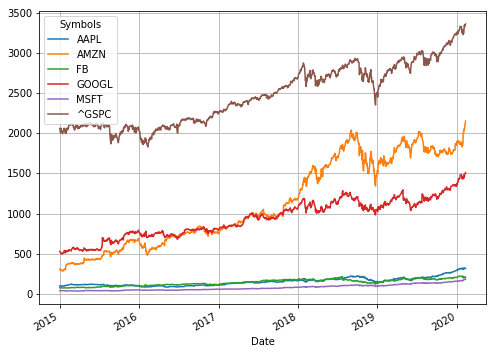

In [5]:
# Gráfico de histórico de precios diarios
closes.plot(figsize=(8,6),grid=True);

### 1.1. Rendimientos porcentuales

Muy bien, pero para el análisis no trabajamos con los precios sino con los rendimientos... **¿porqué?**

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el el cambio porcentual
$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}
$$
para $t=1,\ldots,n$.

*¡Cuidado!* los rendimientos son de acuerdo a la base de tiempo en que se reportan los precios. Por ejemplo: 
- si los precios se reportan en una base diaria, los rendimientos también son diarios;
- si los precios se reportan en una base mensual, los rendimientos también son mensuales.

In [6]:
# Método shift() de un DataFrame...
help(closes.shift)

Help on method shift in module pandas.core.frame:

shift(periods=1, freq=None, axis=0) method of pandas.core.frame.DataFrame instance
    Shift index by desired number of periods with an optional time freq
    
    Parameters
    ----------
    periods : int
        Number of periods to move, can be positive or negative
    freq : DateOffset, timedelta, or time rule string, optional
        Increment to use from the tseries module or time rule (e.g. 'EOM').
        See Notes.
    axis : {0 or 'index', 1 or 'columns'}
    
    Notes
    -----
    If freq is specified then the index values are shifted but the data
    is not realigned. That is, use freq if you would like to extend the
    index when shifting and preserve the original data.
    
    Returns
    -------
    shifted : DataFrame



In [7]:
closes.shift() #desplaza el indice por un periodo 

Symbols,AAPL,AMZN,FB,GOOGL,MSFT,^GSPC
Date,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,100.216454,308.519989,78.449997,529.549988,41.979183,2058.199951
2015-01-06,97.393181,302.190002,77.190002,519.460022,41.593143,2020.579956
2015-01-07,97.402374,295.290009,76.150002,506.640015,40.982681,2002.609985
2015-01-08,98.768150,298.420013,76.150002,505.149994,41.503380,2025.900024
2015-01-09,102.563072,300.459991,78.180000,506.910004,42.724323,2062.139893
2015-01-12,102.673050,296.929993,77.739998,500.720001,42.365219,2044.810059
2015-01-13,100.143120,291.410004,76.720001,497.059998,41.835537,2028.260010
2015-01-14,101.032280,294.739990,76.449997,501.799988,41.620083,2023.030029


In [8]:
# Calcular los rendimientos
ret=((closes-closes.shift())/closes.shift()).dropna()
ret.head()

Symbols,AAPL,AMZN,FB,GOOGL,MSFT,^GSPC
Date,,,,,,
2015-01-05,-0.028172,-0.020517,-0.016061,-0.019054,-0.009196,-0.018278
2015-01-06,0.000094,-0.022833,-0.013473,-0.024679,-0.014677,-0.008893
2015-01-07,0.014022,0.010600,0.000000,-0.002941,0.012705,0.011630
2015-01-08,0.038423,0.006836,0.026658,0.003484,0.029418,0.017888
2015-01-09,0.001072,-0.011749,-0.005628,-0.012211,-0.008405,-0.008404


In [9]:
# Otra forma (más fácil)
ret=closes.pct_change().dropna()
ret.head()

Symbols,AAPL,AMZN,FB,GOOGL,MSFT,^GSPC
Date,,,,,,
2015-01-05,-0.028172,-0.020517,-0.016061,-0.019054,-0.009196,-0.018278
2015-01-06,0.000094,-0.022833,-0.013473,-0.024679,-0.014677,-0.008893
2015-01-07,0.014022,0.010600,0.000000,-0.002941,0.012705,0.011630
2015-01-08,0.038423,0.006836,0.026658,0.003484,0.029418,0.017888
2015-01-09,0.001072,-0.011749,-0.005628,-0.012211,-0.008405,-0.008404


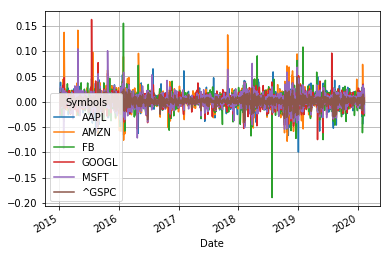

In [10]:
# Graficar...
ret.plot(figsize=(6,4), grid=True)

**¿Qué se observa respecto a los precios?**

Respuestas:
- Los rendimientos parecen conservar tendecias estadísticas constantes (por ejemplo, oscilan al rededor de números cercanos a cero). 

### 1.2. Rendimientos logarítmicos (log-rendimientos)

Otro rendimiento usado con frecuencia es el rendimiento continuamente compuesto o rendimiento logaritmico. Éste, está definido como

$$
r_t=\ln\left(\frac{S_t}{S_{t-1}}\right).
$$

Es fácil darse cuenta que $r_t=\ln(1+R_t)$.

<font color=blue>Ver en el tablero</font> que si $0\leq|x|\ll 1$, entonces $\ln(1+x)\approx x$.

In [11]:
# Calcular rendimientos continuamente compuestos
log_ret=np.log(closes/closes.shift()).dropna()
log_ret.head(2)

Symbols,AAPL,AMZN,FB,GOOGL,MSFT,^GSPC
Date,,,,,,
2015-01-05,-0.028576,-0.020731,-0.016191,-0.019238,-0.009239,-0.018447
2015-01-06,0.000094,-0.023098,-0.013565,-0.024989,-0.014786,-0.008933


In [12]:
# Recordar rendimientos porcentuales. Ver que son similares
ret.head(2)

Symbols,AAPL,AMZN,FB,GOOGL,MSFT,^GSPC
Date,,,,,,
2015-01-05,-0.028172,-0.020517,-0.016061,-0.019054,-0.009196,-0.018278
2015-01-06,0.000094,-0.022833,-0.013473,-0.024679,-0.014677,-0.008893


In [13]:
# Veamos el valor absoluto de la diferencia
np.abs(ret-log_ret).head(3)

Symbols,AAPL,AMZN,FB,GOOGL,MSFT,^GSPC
Date,,,,,,
2015-01-05,4.044376e-04,0.000213,0.000130,0.000184,0.000043,0.000169
2015-01-06,4.454919e-09,0.000265,0.000092,0.000310,0.000109,0.000040
2015-01-07,9.739881e-05,0.000056,0.000000,0.000004,0.000080,0.000067


Por lo anterior, muchas veces se usan para el análisis los rendimientos continuamente compuestos.
___

## 2. Caracterización de la distribución de los rendimientos

Entonces:
- partimos de que tenemos los rendimientos porcentuales diarios de Apple, Walmart, IBM y Nike desde inicios del 2011 a finales del 2015;
- ¿cómo resumirían estos datos?

In [25]:
# Rendimiento medio diario (media aritmética)
mean_ret =ret.mean()
mean_ret

Symbols
AAPL     0.001026
AMZN     0.001680
FB       0.000915
GOOGL    0.000927
MSFT     0.001260
^GSPC    0.000417
dtype: float64

In [26]:
# Volatilidad diaria (desviación estándar)
vol=ret.std()#DESVIACION ESTANDAR 
vol

Symbols
AAPL     0.015672
AMZN     0.018416
FB       0.017795
GOOGL    0.014960
MSFT     0.014703
^GSPC    0.008447
dtype: float64

In [32]:
# Podemos resumir en un DataFrame
ret_summary=pd.DataFrame({'Mean': mean_ret,'Vol':vol})
ret_summary

,Mean,Vol
Symbols,,
AAPL,0.001026,0.015672
AMZN,0.001680,0.018416
FB,0.000915,0.017795
GOOGL,0.000927,0.014960
MSFT,0.001260,0.014703
^GSPC,0.000417,0.008447


Normalmente se reportan rendimientos esperados y volatilidades en una base anual. Para anualizar:

$$E[r_a]=12E[r_m]=252E[r_d]=52E[r_w],\text{ y}$$

$$\sigma_{r_a}=\sqrt{12}\sigma_{r_m}=\sqrt{252}\sigma_{r_d}=\sqrt{52}\sigma_{r_w}$$

In [35]:
# Resumen en base anual
anual_ret_summary=pd.DataFrame({'Mean': mean_ret*252,'Vol':vol*(np.sqrt(252))})# ES DIARIA Y LA QUEREMOS ANUAL
anual_ret_summary

,Mean,Vol
Symbols,,
AAPL,0.258540,0.248788
AMZN,0.423260,0.292342
FB,0.230704,0.282487
GOOGL,0.233518,0.237489
MSFT,0.317572,0.233398
^GSPC,0.105006,0.134087


<function matplotlib.pyplot.show(*args, **kw)>

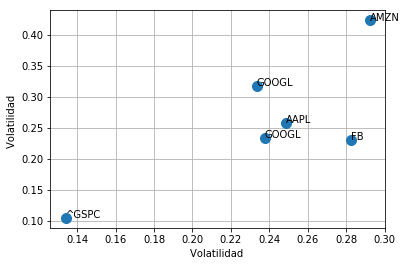

In [63]:
# Gráfico rendimiento esperado vs. volatilidad
import matplotlib.pyplot as plt
# Puntos a graficar
x_points=anual_ret_summary.loc[:,'Vol']
y_points=anual_ret_summary.loc[:,'Mean']
# Ventana para graficar
plt.figure(figsize=(6,4))
# Graficar puntos
plt.plot(x_points,y_points, 'o', ms=10)
plt.grid()
# Etiquetas de los ejes
plt.xlabel('Volatilidad ')
plt.ylabel('Volatilidad ')

# Etiqueta de cada instrumento
plt.text(x_points[0],y_points[0], "AAPL") #ó plt.text(x_points[0],y_points[0],anual_ret_summary.index[0] )
plt.text(x_points[1],y_points[1], "AMZN") #ó plt.text(x_points[1],y_points[1],anual_ret_summary.index[1] )
plt.text(x_points[2],y_points[2], "FB") #ó plt.text(x_points[2],y_points[2],anual_ret_summary.index[2] )
plt.text(x_points[3],y_points[3], "GOOGL")
plt.text(x_points[4],y_points[4], "GOOGL")
plt.text(x_points[5],y_points[5], "^GSPC")
plt.show


### 2.1 Ajuste de curvas con mínimos cuadrados
Consideramos que tenemos un conjunto de n pares ordenados de datos $(\sigma_{r_i},E[r_i])$, para $i=1,2,3,\dots,n$... **en este caso corresponden a volatilidad y rendimiento esperado**

#### ¿Cuál es la recta que mejor se ajusta a estos datos?
Consideramos entonces ajustes de la forma $\hat{f}(\sigma) = \beta_0+\beta_1 \sigma = \left[1 \quad \sigma\right]\left[\begin{array}{c} \beta_0 \\ \beta_1 \end{array}\right]=\left[1 \quad \sigma\right]\boldsymbol{\beta}$ (lineas rectas).

Para decir '*mejor*', tenemos que definir algún sentido en que una recta se ajuste *mejor* que otra.

**Mínimos cuadrados**: el objetivo es seleccionar los coeficientes $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$, de forma que la función evaluada en los puntos $\sigma_{r_i}$ ($\hat{f}(\sigma_{r_i})$) aproxime los valores correspondientes $E[r_i]$.

La formulación por mínimos cuadrados, encuentra los $\boldsymbol{\beta}=\left[\beta_0 \quad \beta_1 \right]^T$ que minimiza
$$\sum_{i=1}^{n}(E[r_i]-\hat{f}(\sigma_{r_i}))^2$$

In [64]:
# Importar el módulo optimize de la librería scipy
from scipy.optimize import minimize

In [65]:
# Funcion minimize
help(minimize) #minimiiza una función escalar

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where x is an 1-D array with shape (n,) and `args`
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see here) <op

In [72]:
# Funcion objetivo y condicion inicial
def objetivo(beta, vol, mean_ret):
    recta= beta[0]+beta[1]*vol
    return ((mean_ret-recta)**2).sum()


In [73]:
# Resolver problema de optimizacion
beta_ini=[0,0]
solucion= minimize(fun=objetivo, x0=beta_ini, args=(anual_ret_summary['Vol'],anual_ret_summary['Mean']))
solucion

      fun: 0.021014126611567287
 hess_inv: array([[ 1.86966733, -7.50249602],
       [-7.50249602, 31.51003484]])
      jac: array([ 2.32830644e-10, -1.86264515e-09])
  message: 'Optimization terminated successfully.'
     nfev: 28
      nit: 4
     njev: 7
   status: 0
  success: True
        x: array([-0.08978333,  1.47508908])

In [79]:
beta_opt=solucion.x

In [80]:
# Ordenar datos con np.sort


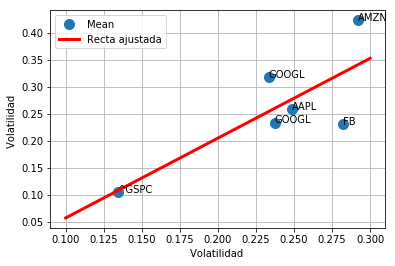

In [81]:
# Gráfico rendimiento esperado vs. volatilidad
import matplotlib.pyplot as plt
# Puntos a graficar
x_points=anual_ret_summary.loc[:,'Vol']
y_points=anual_ret_summary.loc[:,'Mean']
# Ventana para graficar
plt.figure(figsize=(6,4))

# Graficar puntos
plt.plot(x_points,y_points, 'o', ms=10)
plt.grid()
# Etiquetas de los ejes
plt.xlabel('Volatilidad ')
plt.ylabel('Volatilidad ')

# Etiqueta de cada instrumento
plt.text(x_points[0],y_points[0], "AAPL") #ó plt.text(x_points[0],y_points[0],anual_ret_summary.index[0] )
plt.text(x_points[1],y_points[1], "AMZN") #ó plt.text(x_points[1],y_points[1],anual_ret_summary.index[1] )
plt.text(x_points[2],y_points[2], "FB") #ó plt.text(x_points[2],y_points[2],anual_ret_summary.index[2] )
plt.text(x_points[3],y_points[3], "GOOGL")
plt.text(x_points[4],y_points[4], "GOOGL")
plt.text(x_points[5],y_points[5], "^GSPC")
plt.show

#Grafica de recta ajustada
x_recta=np.linspace(0.1,0.3,100)
y_recta=beta_opt[1]*x_recta+beta_opt[0]
plt.plot(x_recta,y_recta,'r',lw=3,label='Recta ajustada')
plt.legend(loc='best')
plt.show()

**¿Qué se puede concluir acerca de la relación entre riesgo (medido con la volatilidad) y el rendimiento esperado (medido con la media)?**

Respuestas:
- Para un rendimiento esperado más alto, se necesita asumir más riesgo.
- La relación entre rendimiento esperado y riesgo es positiva (de acuerdo a los datos).

## 3. Comentarios finales acerca del uso de datos históricos.

### ¡Cuidado!
- Es cierto que los patrones que vemos sobre periodos largos de tiempo en diferentes tipos de intrumentos son muy robustos en términos de la relación rendimiento/riesgo (positiva).
- Por tanto, esperamos rendimientos más altos en el futuro cuando asumimos cierto riesgo.
- ¿Cómo encontramos ese 'rendimiento esperado' en el futuro'? Datos históricos (humanos: tendencia a generalizar)

- Entonces, la idea es que si los rendimientos esperados son un p.e. estacionario, el promedio de muchos rendimientos pasados es una buena estimación del rendimiento esperado futuro (Teorema del límite central).
- ¿Deberíamos pensarlo dos veces?

## SI

Problemas:
- La muestra de datos en el periodo específico de tiempo puede estar sesgada.
- Ventanas de tiempo más grandes reducen especificidad de la muestra y estimados más precisos.
 - Aún así, datos muy viejos pueden ser no representativos.
- Nuevos fondos o estrategias de inversión están a menudo sesgados positivamente:
 - reporte de resultados en tiempos voluntarios;
 - las que mueren (no funcionan), no se reportan;

# Anuncios parroquiales:
## 1. Fin Módulo 1. Revisar que se hayan cumplido los objetivos del módulo (Clase0)
## 2. Tarea: revisar archivo "Tarea3_MidiendoRendimientoRiesgo" en clase. Para el viernes 14 de Febrero.
## 3. Recordar quiz la siguiente clase.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez.
</footer>